## Linear Regression

Linear regression is the most used model in practice, and it is our first parametric model, it has parameters which is calls weights and the algorithm associated with Linear regression concerns itself with finding what those weights will be.

In two dimensions Linear regression is easy to explain:

<blockquote>
Find the line of best fit through the X and y points.
</blockquote>

In more than two dimensions it becomes:

<blockquote>
Find the hyperplane of best fit through the X and y points.
</blockquote>

In order to fully understand Linear Regression and any ML algorithm we can go back to the drawing board. Let's return to our assumptions and check to see what a machine learning algorithm entails:

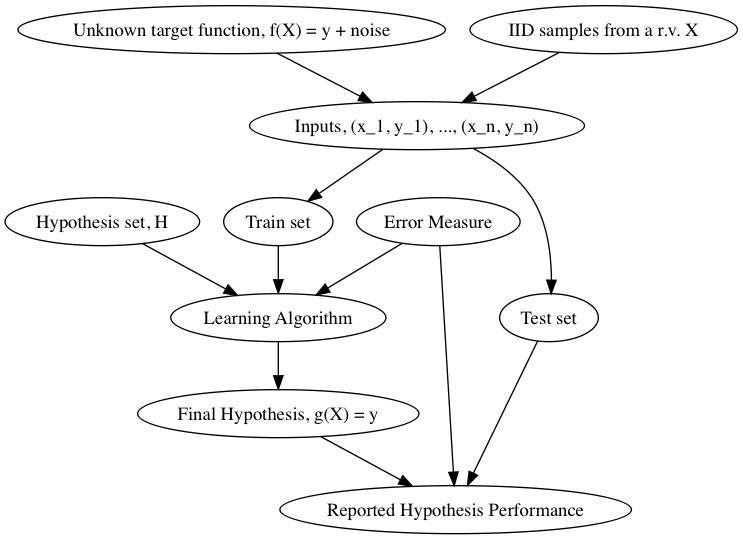

In [14]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

c0 = 'Unknown target function, f(X) = y + noise'
c1 = 'Inputs, (x_1, y_1), ..., (x_n, y_n)'
c2 = 'Learning Algorithm'
c3 = 'Hypothesis set, H'
c4 = 'Final Hypothesis, g(X) = y'
c5 = 'IID samples from a r.v. X'
c6 = 'Train set'
c7 = 'Test set'
c8 = 'Reported Hypothesis Performance'
c9 = 'Error Measure'

nodes = [c0, c1, c2, c3, c4, c5, c6, c7, c8, c9]

G = nx.DiGraph()

for n in nodes:
    G.add_node(n)

G.add_edge(c0, c1)
G.add_edge(c3, c2)
G.add_edge(c2, c4)
G.add_edge(c5, c1)
G.add_edge(c1, c6)
G.add_edge(c1, c7)
G.add_edge(c6, c2)
G.add_edge(c7, c8)
G.add_edge(c4, c8)
G.add_edge(c9, c8)
G.add_edge(c9, c2)


draw(G)

To do that we can refer back to our assumptions. So the machine learning algorithm is composed of five parts of the above diagram:

0. Inputs
1. Hypothesis Set
2. Learning Algorithm
3. Error Measure
3. Final Hypothesis

Notice that we have added error measure from our last description, as we will see that this will become more important in the future.  

#### Inputs and Outputs

Linear regression (and regression tasks in general) are for quantitative outcomes. So we will not be able to predict 

The second concern is about the inputs. Some models need very specific inputs. So for example, or linear regression can only take quantitative features, so we need to make sure to convert all the values to quantitative ones before the regression. The second point that needs to be made is whether the data needs to be standardized. For linear regression the answer is two parts: no, unless there are interaction or quadratic terms (which you can read about [here](http://www.stat.columbia.edu/~gelman/research/published/ape17.pdf).

In summary two points:

1. Linear Regression is a regression model, thus has quantitative outputs
2. Linear regression can only take quantitative features which should be normalized if using interaction or quadratic terms.

#### Hypothesis Set

The hypothesis set is pretty simple for linear regression. We consider all w's such that:

$$ y = w_0 + w_1 * x_1 + ... + w_n * x_n$$

Where y is the target and each $x_i$ is a particular feature. So once again our hypothesis set is infinite. That being said we have a bit more of a handle on the infiniteness of the set. In fact an easy way to tell how infinite our hypothesis set is to count the number of infinite parameters and in linear regression we get n + 1 infinite parameters.

#### Learning Algorithm

There are actually three ways to get to the learning algorithm behind linear regression (a statistical way, a mathematical way, and a functional approximation way). But the important thing to know about it is that it is extremely fast and memory efficient. 

#### Error Measure

The learning algorithm seeks to minimize a specific error measure, and the error measure that it seeks to minimize is mean squared error:

$$ (y - \widehat{y})^2 $$

Where $\widehat{y}$ is our predictions. So simply put we minimize the squared difference between our predictions and the true values. This is partially to defend us against negative error and partially because of the mathematical and statistical derivations. 

One thing to note here is that this is really hard to understand, and typically people use other measures when talking about the performance of linear regression.

#### Final hypothesis

The final hypothesis is simply the set of weights associated with the formula above. So it is easy to store and quick to evaluate.

Let's explore what using linear regression feels like:

In [27]:
import pandas as pd
import numpy as np

# we now consolidate the preprocessing
def billionaire_preprocess():
    data = pd.read_csv('../data/billionaires.csv')

    del data['was founder']
    del data['inherited']
    del data['from emerging']

    data.age.replace(-1, np.NaN, inplace=True)
    data.founded.replace(0, np.NaN, inplace=True)
    data.gdp.replace(0, np.NaN, inplace=True)
    
    del data['company.name']
    del data['name']
    del data['country code']
    del data['citizenship']
    del data['rank']
    del data['relationship']
    del data['sector']
    
    dummy_data = pd.get_dummies(data, dummy_na=True, columns=data.select_dtypes(exclude=['float64']), drop_first=True)
    
    return dummy_data

In [28]:
# now we get the data
data = billionaire_preprocess()

In [29]:
# we parse out the target
y = data['worth in billions']
del data['worth in billions']

In [30]:
# now we split the data
from sklearn.model_selection import train_test_split

# we make our test set
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [31]:
print X_train.shape, X_val.shape, X_test.shape

(1672, 70) (419, 70) (523, 70)


Now that we have our new target and split let's isolate the features:

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

# We then consolidate the data munging code
def billionaire_feature_eng(X, y, quantitative_pipeline, aggregated_pipeline, training=False):
    data = X.copy()

    qualitative_features = data.select_dtypes(exclude=['float64'])
    quantitative_features = data.select_dtypes(include=['float64'])
    
    # notice how we only fit on the training data!
    if training:
        quant_X = quantitative_pipeline.fit_transform(quantitative_features)
    else:
        quant_X = quantitative_pipeline.transform(quantitative_features)

    X = np.concatenate([quant_X, qualitative_features], axis=1)
    
    if training:
        X = aggregated_pipeline.fit_transform(X, y)
    else:
        X = aggregated_pipeline.transform(X)
    
    return X, y

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression

# and we can abstract out specific parts of the pipeline
quantitative_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median'))
])

aggregated_pipeline = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=0.0)),
    ('k_best', SelectKBest(mutual_info_regression, k=3))
])

In [34]:
X_train, y_train = billionaire_feature_eng(X_train, y_train, quantitative_pipeline, aggregated_pipeline, training=True)

In [35]:
# let's check out the features we are using
data.columns[aggregated_pipeline.steps[0][1].get_support()][aggregated_pipeline.steps[1][1].get_support()]

Index([u'founded', u'industry_Consumer', u'industry_Diversified financial'], dtype='object')

Let's visualize how using linear regression would work with the above columns individually:

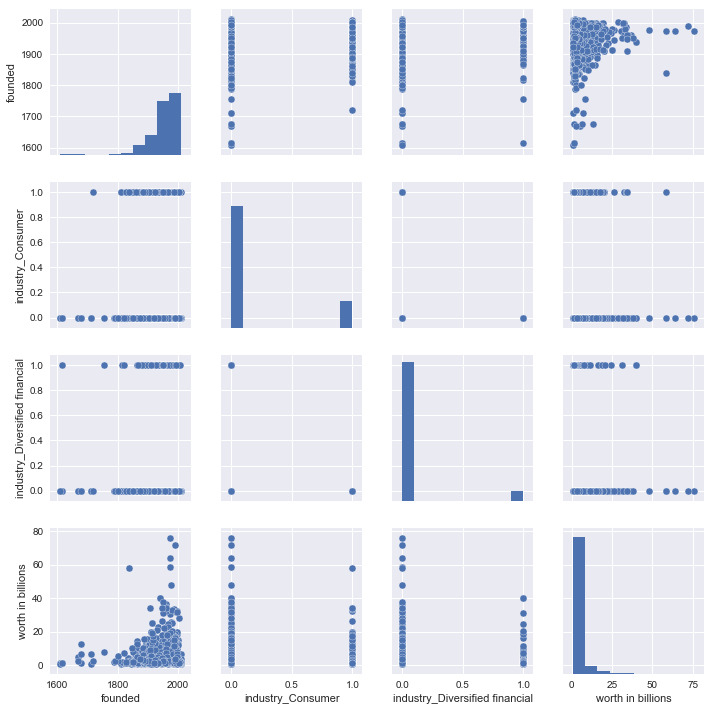

In [57]:
%matplotlib inline
import seaborn as sns

cols = list(data.columns[aggregated_pipeline.steps[0][1].get_support()][aggregated_pipeline.steps[1][1].get_support()])
cols += ['worth in billions']
# a little bit of a no no here, we should really use just the train data
sns.pairplot(billionaire_preprocess()[cols].dropna())

You can see that there are certain trends in the data, newer founded startups tend to be worth more in billions. One of the weaknesses with linear regression however is that it cannot naively capture non-linear interactions. So perhaps two of the features above interact in a specific way, linear regression cannot find this out on its own.

Let's finish by doing the linear regression and then expaining its most common error measure:

In [59]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=True)

In [62]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
# we can see the model here
reg.coef_

array([ 0.00254758,  0.34734013,  1.66156609])

In [63]:
X_val, y_val = billionaire_feature_eng(X_val, y_val, quantitative_pipeline, aggregated_pipeline)

# first we show the R^2
reg.score(X_val, y_val)

-0.02461775285690071

In [65]:
from sklearn.metrics import mean_absolute_error

# second we show the mean absolute error
mean_absolute_error(reg.predict(X_val), y_val)

2.2796817845637318

## How'd we do

We showed to measures: r-squared and MAE:

* Mean Absolute Error: the MAE is how off we are on average. This is generally more business interpretable than MSE
* R squared: this gives you the percent of the variance that the model explains. You would be happy to get a model with over .8 r squared (note the sklearn returns the negative r squared.

So in short, linear regression did not do too well. Perhaps one of the reasons is because of interactions in the data. 

One final trick that we will use is to use a dummy regressor which will apply a very simple strategy and see how well it works in practice. Ours will simply return the mean of the training data:

In [68]:
from sklearn.dummy import DummyRegressor

dummy_preds = DummyRegressor().fit(X_train, y_train).predict(X_val)

mean_absolute_error(dummy_preds, y_val)

2.233611869226114

Pretty sad right, we only did 2 or 3% better than the dummy, we have a ways yet to go!